In [1]:
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table

plt.rcParams['figure.facecolor']    = 'white'

from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
# from utils import *

06_18_24


In [2]:
files = glob.glob('../data/p112_data_24/*.fits')
files = glob.glob('../data/spectra/*.fits')


In [3]:
import pymc as pm
import corner
import arviz as az


In [4]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

In [5]:
# spectrum = fits.open('../data/spectra/archive/ADP.2023-12-08T12:58:09.704.fits')
# header = spectrum[0].header
# data   = spectrum[1].data

In [6]:
# instrument precision: cm/s
# decription of columns: https://ftp.eso.org/pub/dfs/pipelines/instruments/espresso-das/espda-reflex-tutorial-1.3.7.pdf
# QC CCF RV: computed radial velocity [km s−1

In [7]:
# header.cards

In [8]:
obj_dir = {}
c=3e5 #km/s

for i,file in enumerate(files):
    with fits.open(file) as hdul:
        hdul = fits.open(file)
        header  = hdul[0].header
        #print(header.cards['HIERARCH ESO QC CCF RV ERROR'])
        data    = hdul[1].data
        time    = header['HIERARCH ESO QC BJD']
        name    = header['OBJECT']
        obj     = int(header['HIERARCH ESO OBS NAME'].split('-')[0][2:])
        #print(obj)
        ra,dec  = header['RA'], header['DEC']
        obs_T   = header['DATE-OBS'].split('T')[0]
        rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
        rv_err  = header['HIERARCH ESO QC CCF RV ERROR'] #km/s
        sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
        rv_corr = rv_val
        err_corr = rv_err
        # correct for Earth's motion:
#         rv_corr = sc.radial_velocity_correction(kind='barycentric', obstime=Time(obs_T), location=vlt).to(u.km/u.s).value #to convert to km/s
#         err_corr = sc.radial_velocity_correction(kind='barycentric', obstime=Time(obs_T), location=vlt).to(u.km/u.s).value
#         rv_corr = rv_val + rv_corr + rv_val * rv_corr / c  
        #err_corr = rv_err + err_corr + rv_err * err_corr / c  
        
        if obj in obj_dir.keys():
            obj_dir[obj]['rv'].append(rv_corr)
            obj_dir[obj]['time'].append(time)
            obj_dir[obj]['err'].append(err_corr)
            obj_dir[obj]['name'].append(name)
        else:
            obj_dir[obj] = {'rv': [rv_corr], 'time': [time], 'err': [err_corr], 'name': [name]}
            
targets_to_remove = []
for k, v in obj_dir.items():
    if len(v['time']) < 3:
        targets_to_remove.append(k)
for i in range(len(targets_to_remove)):
    del obj_dir[targets_to_remove[i]]
print(len(obj_dir.keys()))

myKeys = list(obj_dir.keys())
myKeys.sort()
obj_dir = {i: obj_dir[i] for i in myKeys}
 

10


1 0.16986580912364957
2 0.15293635502399994
4 0.2451852268868997
5 0.580356837546951
6 0.6518581581411201
7 0.33829807786749
13 14.615809339959851
14 0.17943440233025143
23 6.39697151489245
24 0.14459279697440053


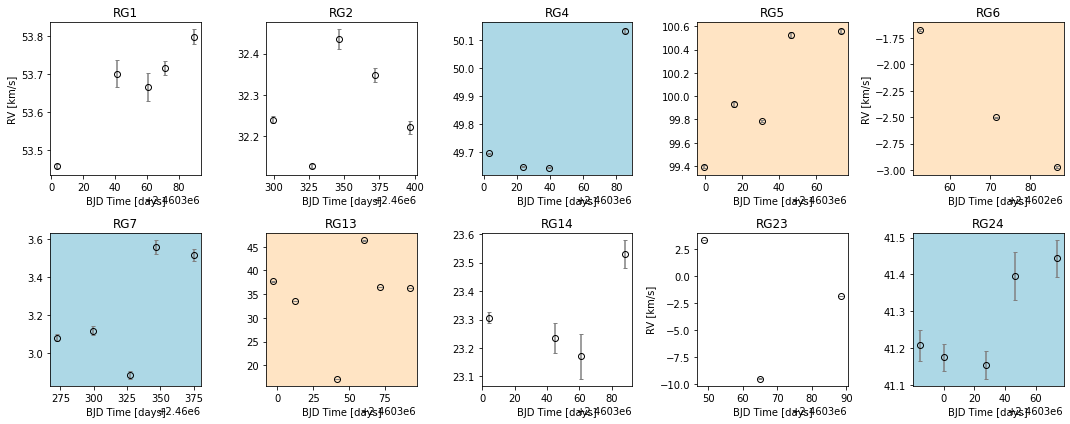

In [9]:
#PLOT_PARAMS(LS=12)
plt.figure(figsize=(15,6))
for i, (obj, dat) in enumerate(obj_dir.items()):
    if len(dat['time']) > 1:
        #print(obj,obj_dir[obj])
        ax=plt.subplot(2,5,i+1)
        time    = np.array(obj_dir[obj]['time'])
        rv_vals = np.array(obj_dir[obj]['rv'])
        t0  = time[0]
        rv0 = rv_vals[0]
        K0 = (max(rv_vals)-min(rv_vals))/2.
        yerr = obj_dir[obj]['err']
        print(obj, K0)
        plt.errorbar(time, rv_vals, 
                     yerr=yerr,
                     fmt='o', color='grey', mec='k', mfc='None', capsize=2)
        #plt.axhline(0, color='k',lw=1,ls='dotted')
        title = 'RG%s'%obj
        plt.title(title)
        if title in ['RG13','RG5','RG6']:
            ax.set_facecolor('bisque')
        elif title in ['RG4','RG24','RG13','RG7']:
            ax.set_facecolor('lightblue')
    plt.xlabel(r'BJD Time [days]')
    if i+1 in [1,5,9,13]: plt.ylabel(r'RV [km/s]')

plt.tight_layout()
# plt.savefig('../plots/init_%s.png'%DATE, bbox_inches='tight', dpi=200)

In [11]:
import thejoker as tj
import thejoker.units as xu
from utils import PLOT_PARAMS

In [56]:
def test_tj(obj,prior_size=50_000,save=False,MCMC=False):
    data = Table()
    data['bjd'] = obj_dir[obj]['time']
    data['rv'] = obj_dir[obj]['rv']
    data['rv_err'] = obj_dir[obj]['err']
    t = Time(data["bjd"], format="jd", scale="tcb")
    
    rnd = np.random.default_rng(seed=42)
    
    data = tj.RVData(t=t, rv=data["rv"]*u.km/u.s, rv_err=data["rv_err"]*u.km/u.s)
    
    with pm.Model() as model:
        P_prior = xu.with_unit(pm.Uniform("P", 2, 5e3), u.day)
        K_prior = xu.with_unit(pm.Normal("K", 0, 10), u.km/u.s)
        prior = tj.JokerPrior.default(
                #P_min=2 * u.day,
                #P_max=1e3 * u.day,
                sigma_K0=10 * u.km / u.s,
                sigma_v=100 * u.km / u.s,
                pars={'P':P_prior, 'K':K_prior}
        )

    prior_samples = prior.sample(size=prior_size, rng=rnd)
    print(prior_samples)
    
    joker = tj.TheJoker(prior, rng=rnd)

    joker_samples_1 = joker.rejection_sample(data, prior_samples, 
                                             max_posterior_samples=256,
                                            return_all_logprobs=True)
    
    prior_samples = prior.sample(size=prior_size, rng=rnd)
    print(prior_samples)
    
    joker = tj.TheJoker(prior, rng=rnd)

    joker_samples_2 = joker.rejection_sample(data, prior_samples, 
                                             max_posterior_samples=256,
                                             return_all_logprobs=True)
    
    #     _ = tj.plot_rv_curves(joker_samples, data=data)

    PLOT_PARAMS()
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    _ = tj.plot_rv_curves(
        joker_samples_1[0],
        data=data,
        relative_to_t_ref=True,
        ax=ax,
    )
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    _ = tj.plot_rv_curves(
        joker_samples_2[0],
        data=data,
        relative_to_t_ref=True,
        ax=ax,
    )
    
    ax.set_xlabel(f"BMJD$ - {data.t.tcb.mjd.min():.3f}$")
    if save: fig.savefig('../rv_fit/fit_RG%s_%s.png'%(obj,DATE),bbox_inches='tight',dpi=100)
    if MCMC:
        
        with prior.model:
            mcmc_init = joker.setup_mcmc(data, joker_samples)
            trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)

        az.summary(trace, var_names=prior.par_names)
        
        mcmc_samples = tj.JokerSamples.from_inference_data(prior, trace, data)
        mcmc_samples.wrap_K()
        df = mcmc_samples.tbl.to_pandas()
        colnames = []
        truth = ['P','e','omega','M0','K','v0']
        for name in df.columns:
            if name in truth:
                colnames.append(name)
                #truths.append(truth[name].value)
        fig = corner.corner(df[colnames])#, truths=truths)
        if save: fig.savefig('../rv_fit/RG%s_corner_%s.png'%(obj, DATE),bbox_inches='tight',dpi=100)
    return joker_samples_1, joker_samples_2



In [ ]:
binaries = [23, 13, 7, 6, 5, 4, 1]

In [ ]:
ss

<JokerSamples [e, omega, M0, s, P] (50000 samples)>
<JokerSamples [e, omega, M0, s, P] (50000 samples)>


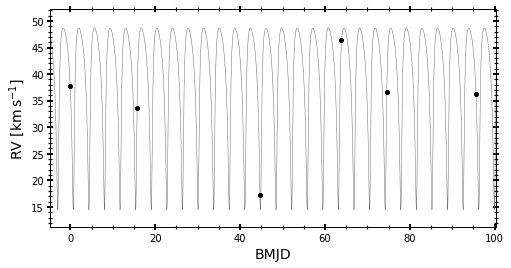

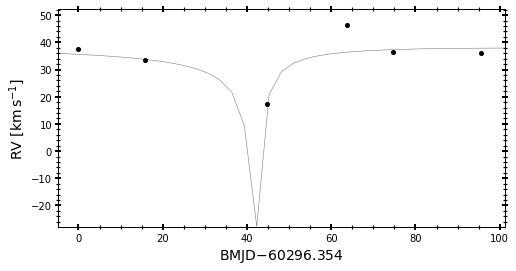

In [57]:
ts1, ts2 = test_tj(13,prior_size=50_000,save=False,MCMC=False)

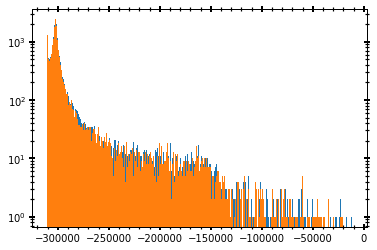

In [63]:
_=plt.hist(ts1[1],bins='auto')
_=plt.hist(ts2[1],bins='auto')
plt.yscale('log')


<JokerSamples [e, omega, M0, s, P] (50000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>


<ipython-input-38-a142d858bd98>:47: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
NUTS: [P, K, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, v0]
INFO:pymc.sampling.mcmc:NUTS: [P, K, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, v0]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 79 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 79 seconds.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems

(<JokerSamples [e, omega, M0, s, P] (50000 samples)>,
 <JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>)

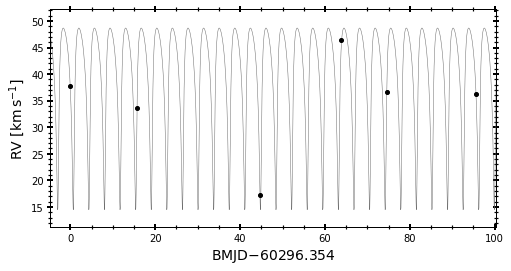

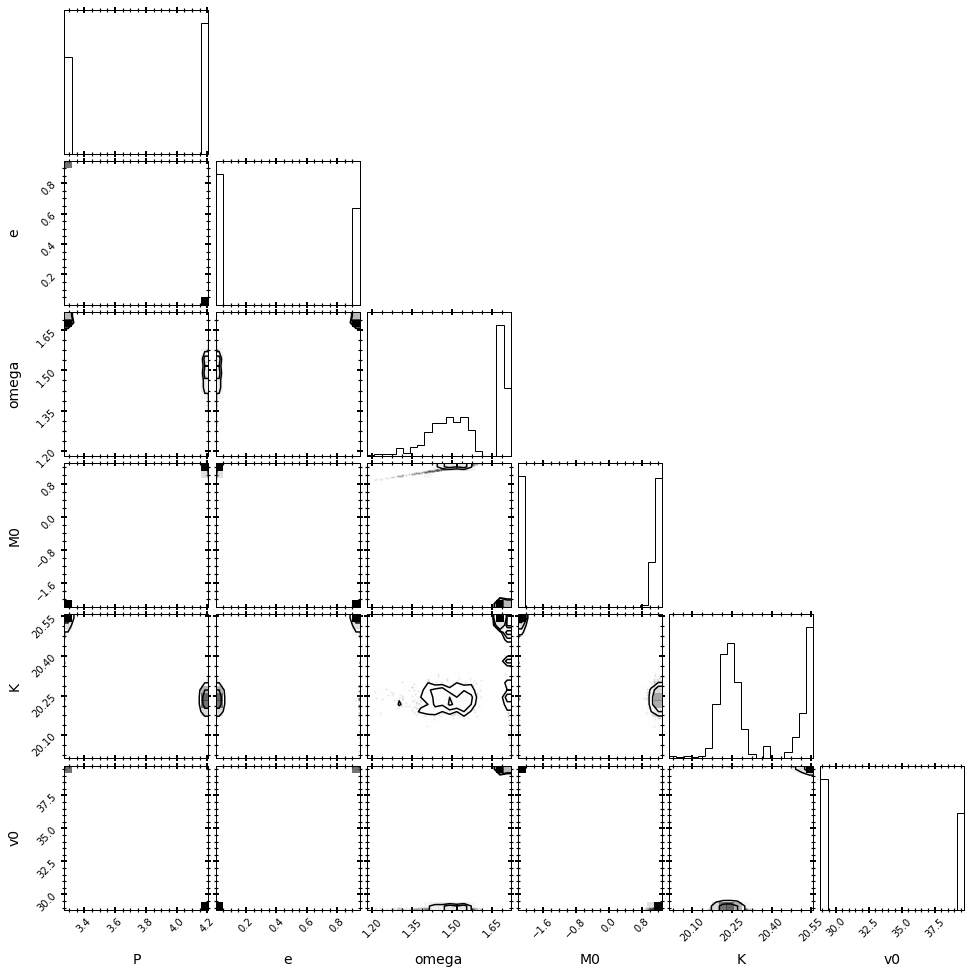

In [40]:
test_tj(13,prior_size=50_000,save=False,MCMC=True)

<JokerSamples [e, omega, M0, s, P] (2500000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>


<ipython-input-29-b902ccd59c04>:45: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
NUTS: [P, K, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, v0]
INFO:pymc.sampling.mcmc:NUTS: [P, K, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, v0]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 26 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 26 seconds.
There were 645 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 645 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smal

(<JokerSamples [e, omega, M0, s, P] (2500000 samples)>,
 <JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>)

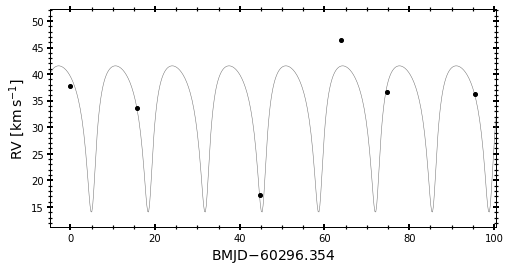

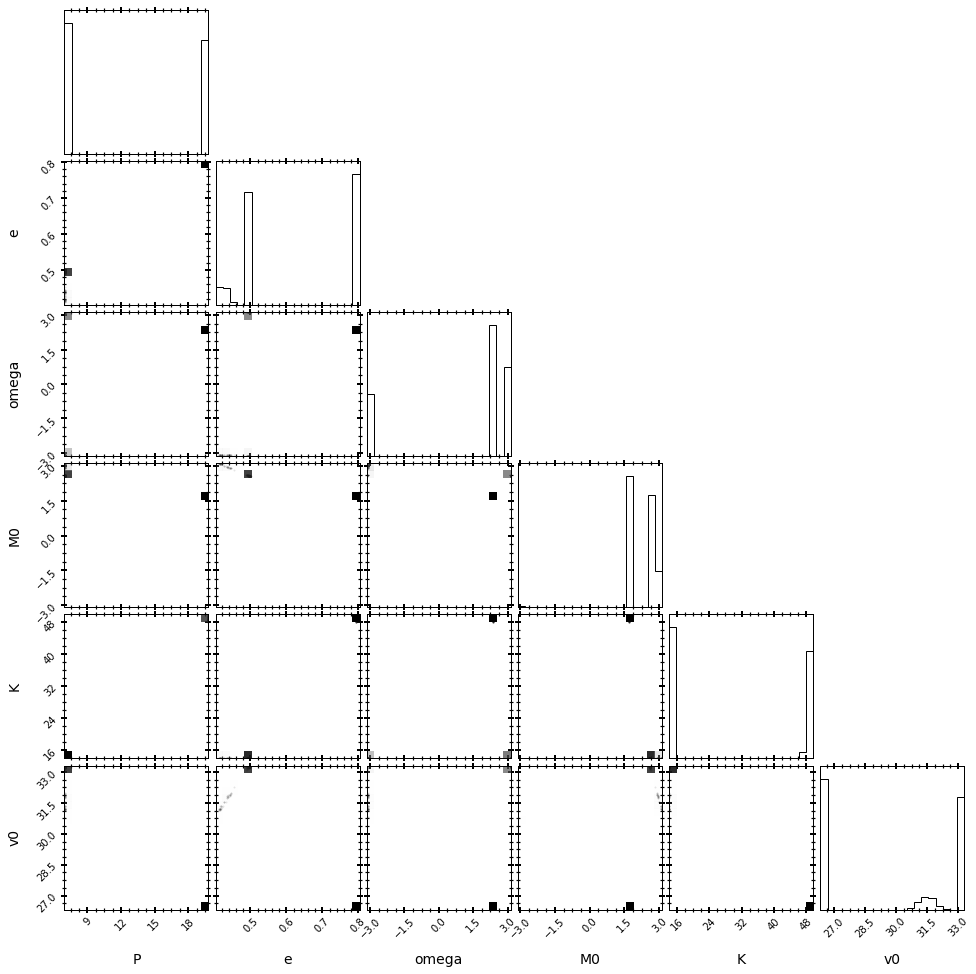

In [30]:
test_tj(13,prior_size=2_500_000,save=False,MCMC=True)

<JokerSamples [e, omega, M0, s, P] (250000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>


(<JokerSamples [e, omega, M0, s, P] (250000 samples)>,
 <JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>)

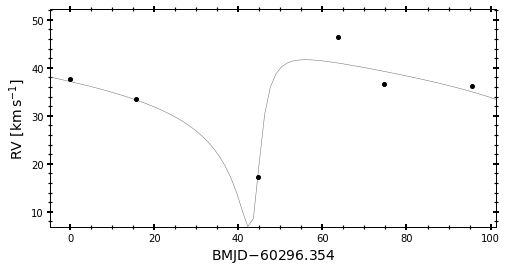

In [32]:
test_tj(13,prior_size=250_000,save=False,MCMC=False)

<JokerSamples [e, omega, M0, s, P] (50000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>


(<JokerSamples [e, omega, M0, s, P] (50000 samples)>,
 <JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>)

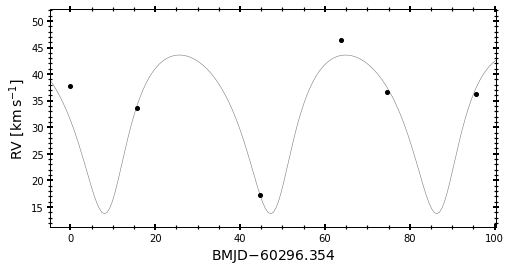

In [27]:
test_tj(13,prior_size=250_000,save=False,MCMC=False)

(array([4927., 5089., 5031., 5033., 5034., 4932., 4949., 5021., 5038.,
        4946.]),
 array([2.01281950e+00, 5.01807370e+02, 1.00160192e+03, 1.50139647e+03,
        2.00119102e+03, 2.50098557e+03, 3.00078012e+03, 3.50057467e+03,
        4.00036922e+03, 4.50016377e+03, 4.99995832e+03]),
 <BarContainer object of 10 artists>)

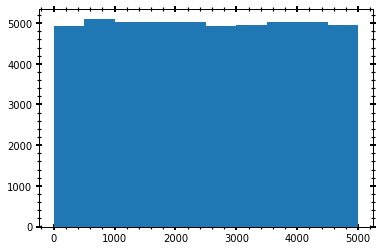

In [37]:
plt.hist(prior_samples_dict[13]['P'].to_value())


<JokerSamples [e, omega, M0, s, P] (50000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>


(<JokerSamples [e, omega, M0, s, P] (50000 samples)>,
 <JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>)

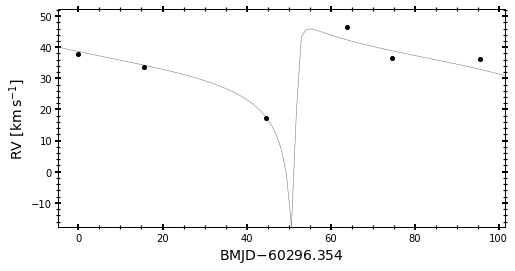

In [26]:
test_tj(13,prior_size=250_000,save=False,MCMC=False)

<JokerSamples [e, omega, M0, s, P] (50000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>


<ipython-input-24-ba4e28793182>:45: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
NUTS: [P, K, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, v0]
INFO:pymc.sampling.mcmc:NUTS: [P, K, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, v0]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 88 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 88 seconds.
There were 500 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 500 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems

(<JokerSamples [e, omega, M0, s, P] (50000 samples)>,
 <JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>)

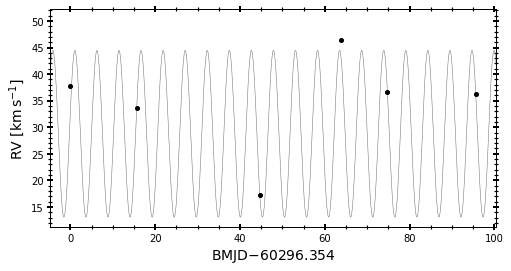

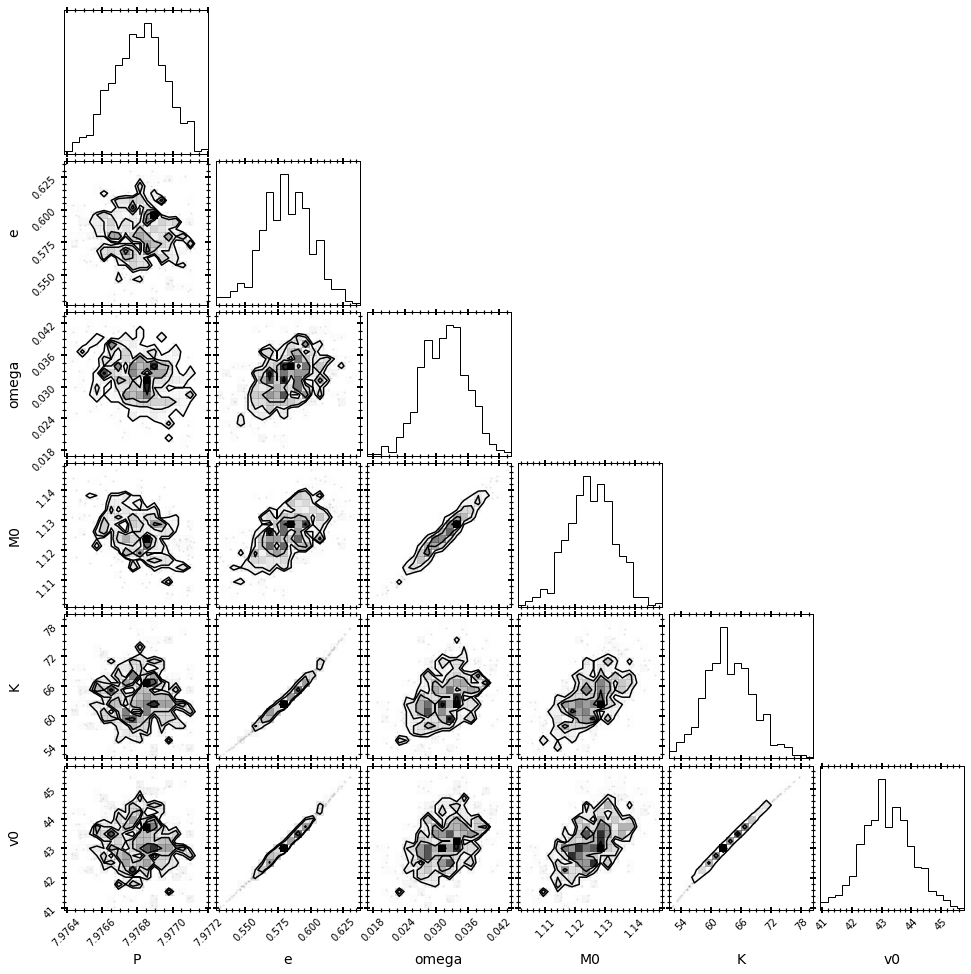

In [25]:
test_tj(13,prior_size=250_000,save=False,MCMC=True)

<JokerSamples [e, omega, M0, s, P] (50000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0] (2 samples)>


<ipython-input-12-9d146ed0d23f>:44: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 23 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/opt/miniconda3/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


<JokerSamples [e, omega, M0, s, P] (50000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0] (2 samples)>


<ipython-input-12-9d146ed0d23f>:44: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]
INFO:pymc.sampling.mcmc:NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 223 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 223 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
I

<JokerSamples [e, omega, M0, s, P] (50000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>


<ipython-input-12-9d146ed0d23f>:44: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]
INFO:pymc.sampling.mcmc:NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 89 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 89 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smalle

<JokerSamples [e, omega, M0, s, P] (50000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0] (157 samples)>


<ipython-input-12-9d146ed0d23f>:44: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]
INFO:pymc.sampling.mcmc:NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 217 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 217 seconds.
There were 143 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 143 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details

<JokerSamples [e, omega, M0, s, P] (50000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0] (2 samples)>


<ipython-input-12-9d146ed0d23f>:44: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]
INFO:pymc.sampling.mcmc:NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 32 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 32 seconds.
There were 323 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 323 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smal

<JokerSamples [e, omega, M0, s, P] (50000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>


<ipython-input-12-9d146ed0d23f>:44: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]
INFO:pymc.sampling.mcmc:NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 12 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 12 seconds.
There were 813 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 813 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smal

<JokerSamples [e, omega, M0, s, P] (50000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0] (141 samples)>


<ipython-input-12-9d146ed0d23f>:44: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]
INFO:pymc.sampling.mcmc:NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 152 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 152 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems

<JokerSamples [e, omega, M0, s, P] (50000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>


<ipython-input-12-9d146ed0d23f>:44: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]
INFO:pymc.sampling.mcmc:NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 26 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 26 seconds.
There were 717 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 717 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smal

<JokerSamples [e, omega, M0, s, P] (50000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0] (256 samples)>


<ipython-input-12-9d146ed0d23f>:44: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]
INFO:pymc.sampling.mcmc:NUTS: [P, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, K, v0]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 110 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 110 seconds.
There were 212 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 212 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is sm

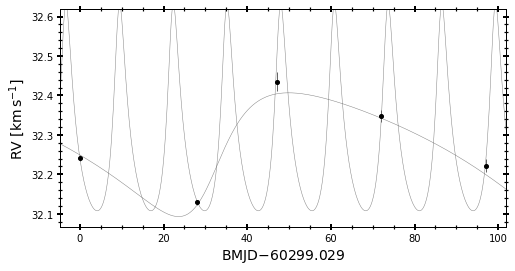

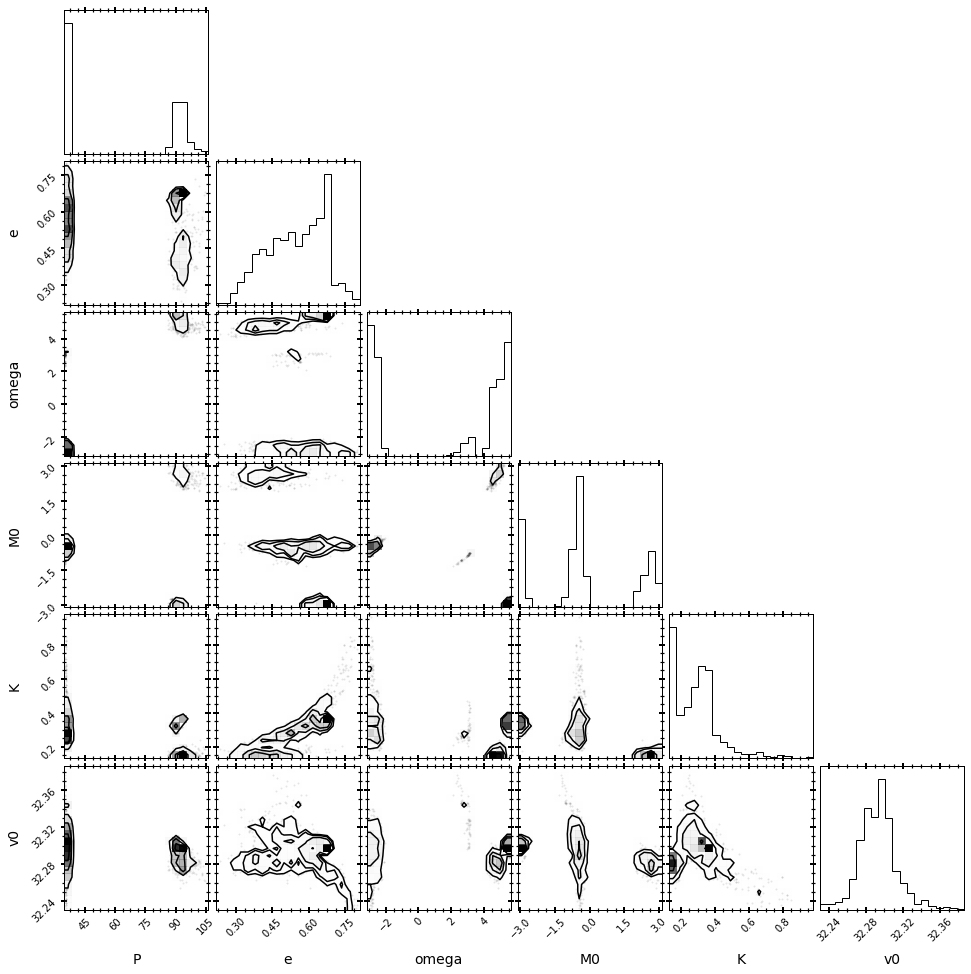

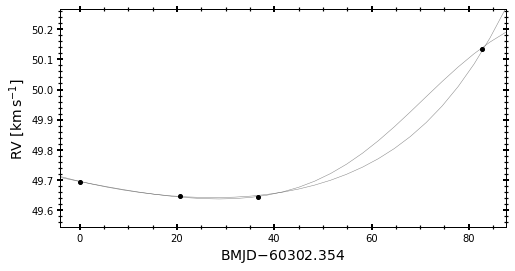

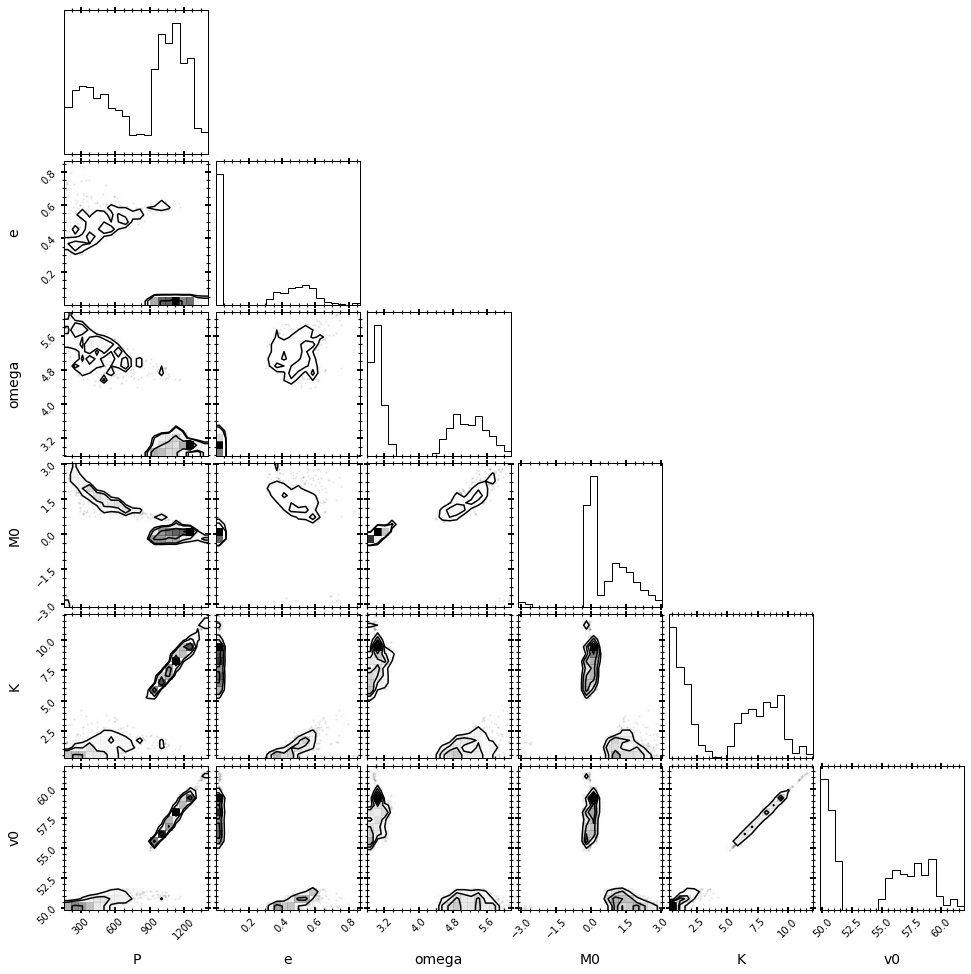

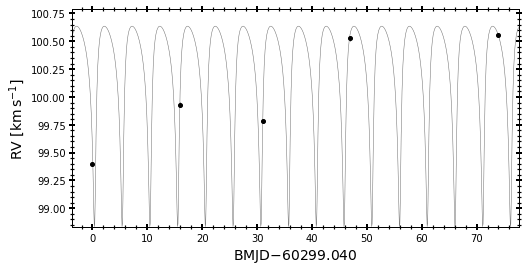

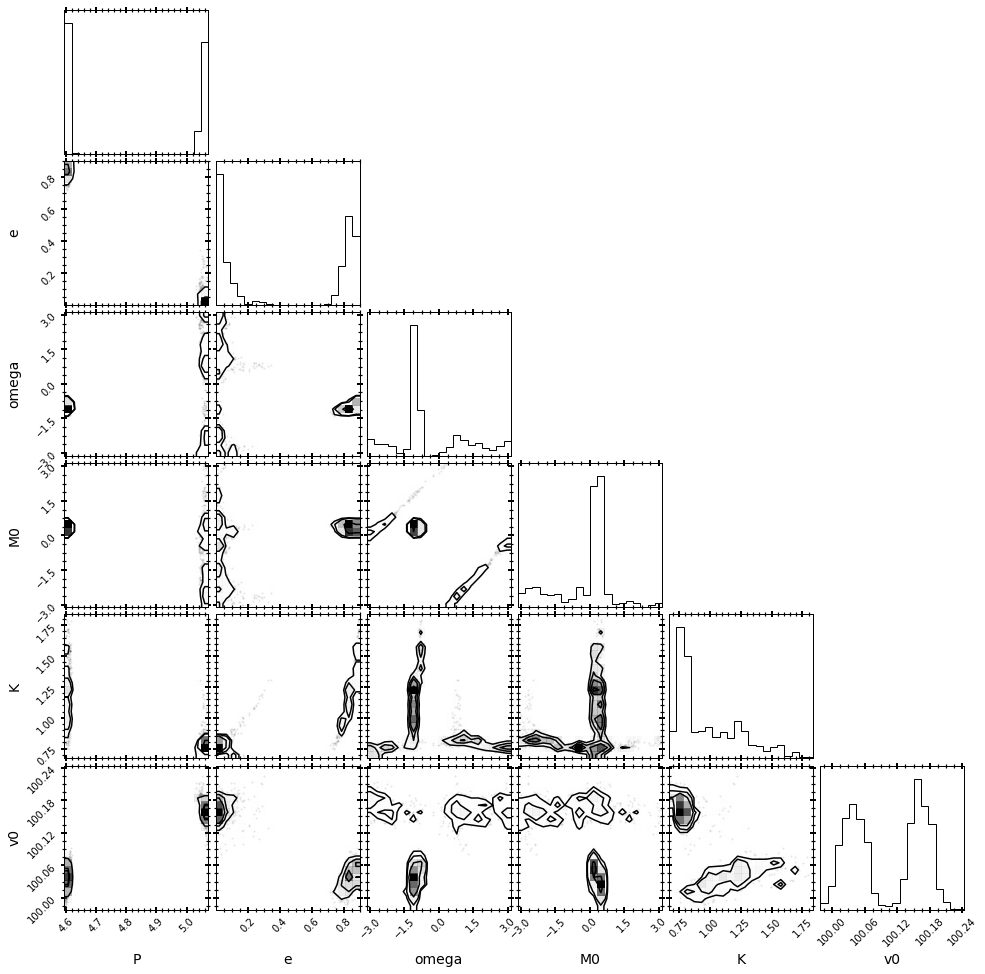

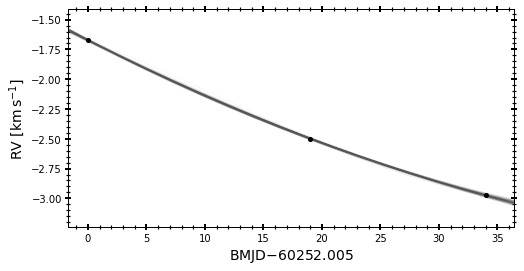

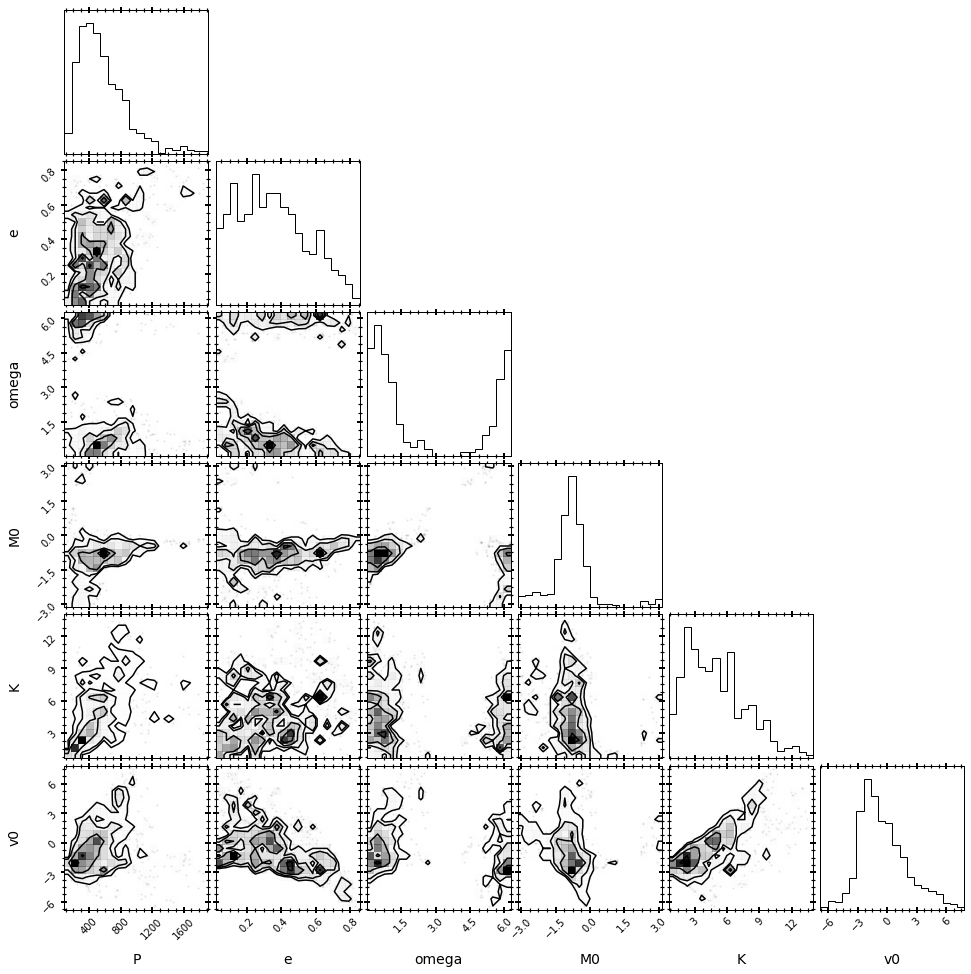

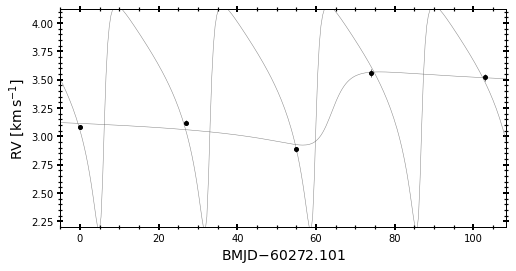

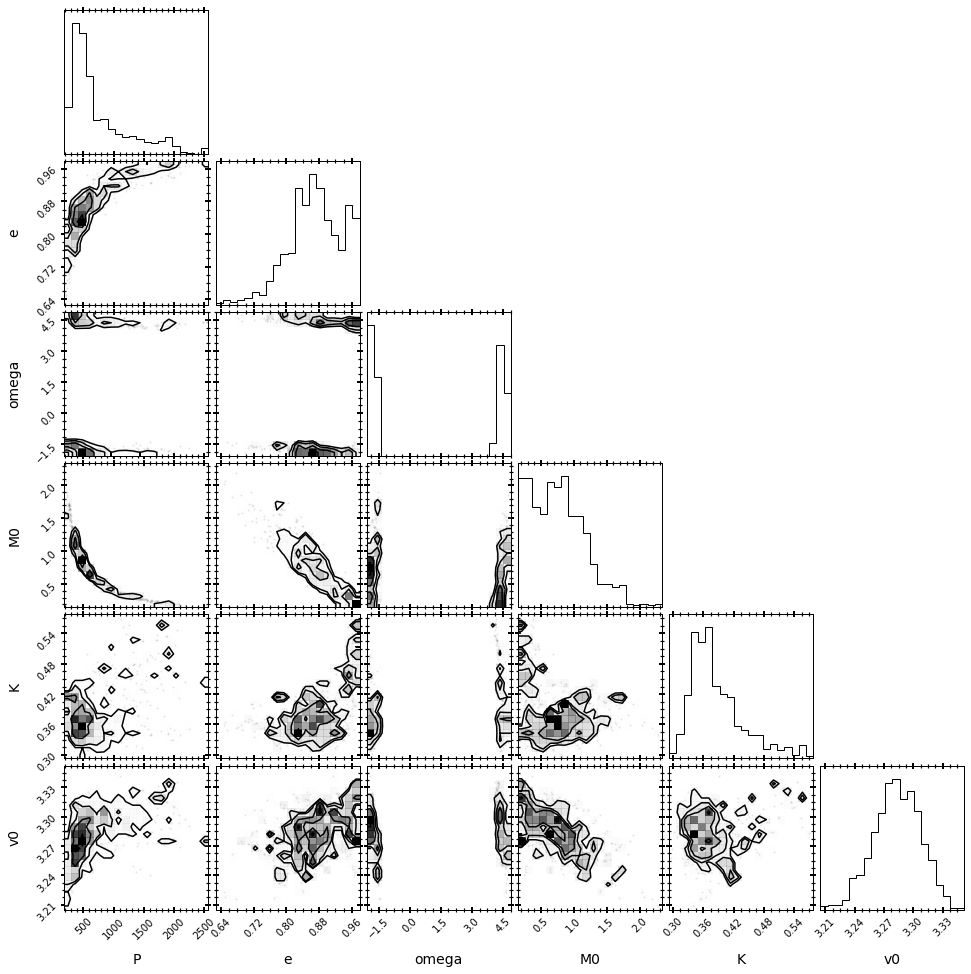

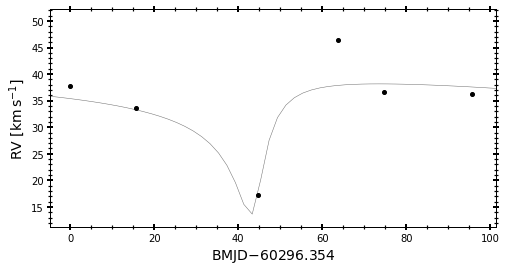

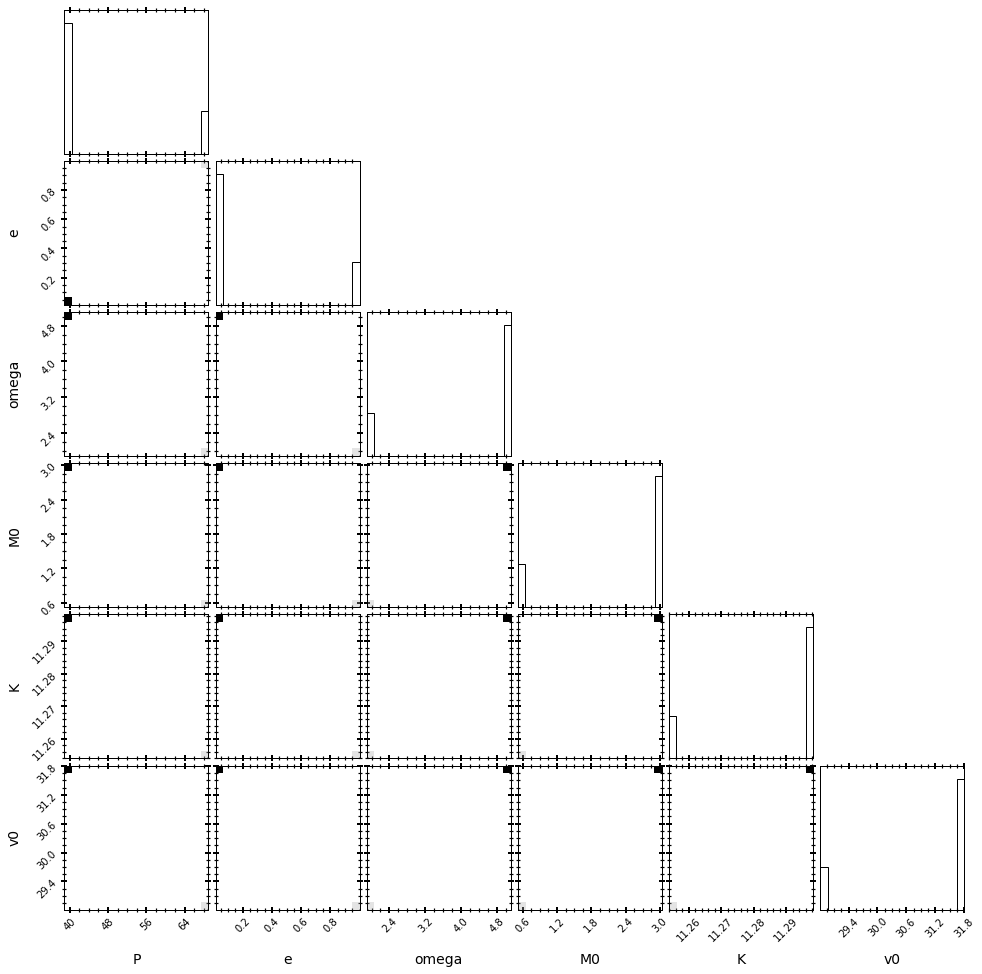

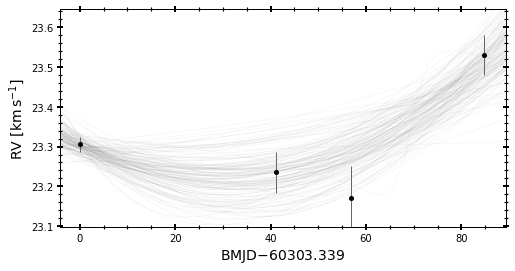

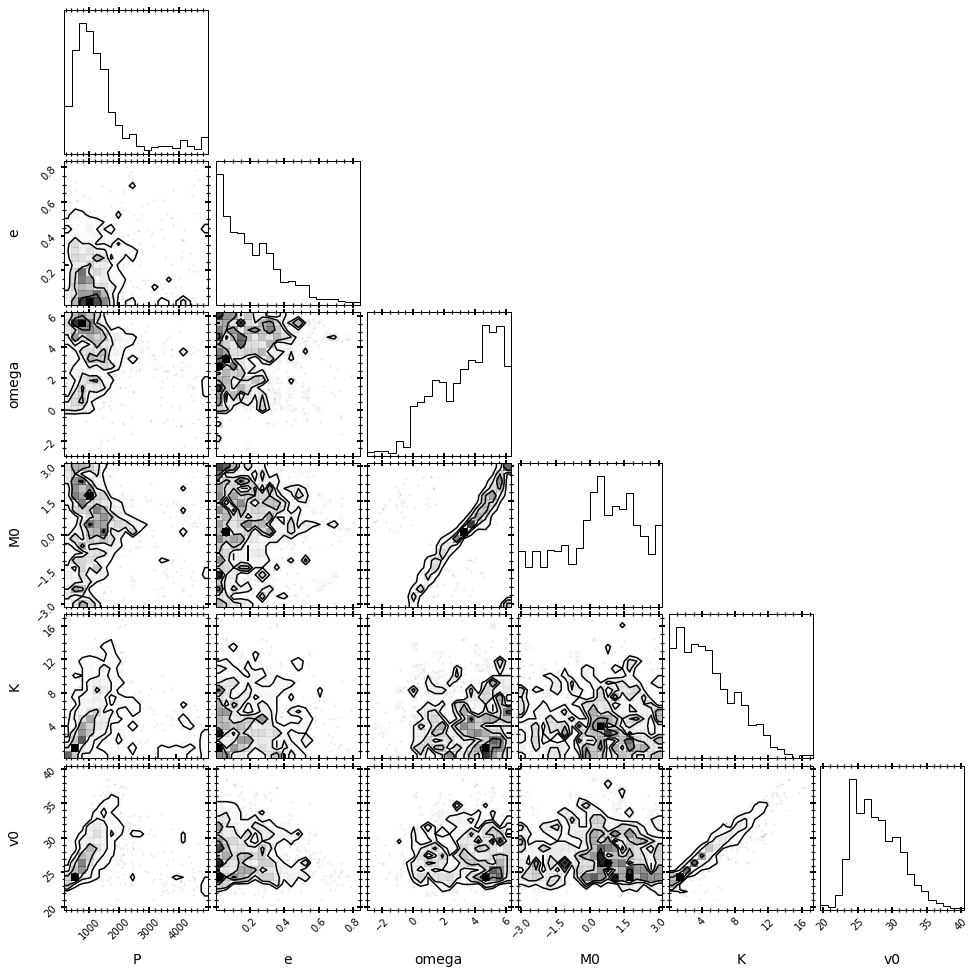

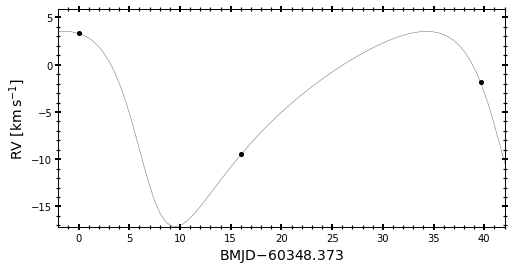

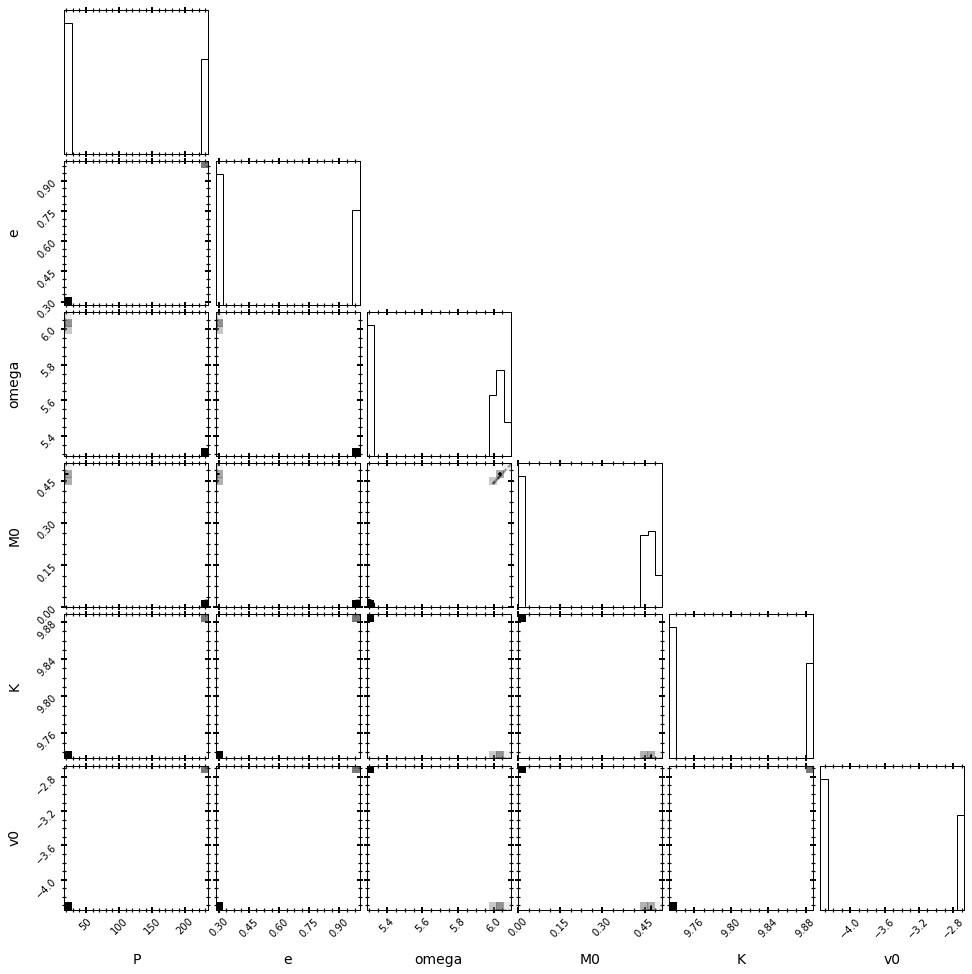

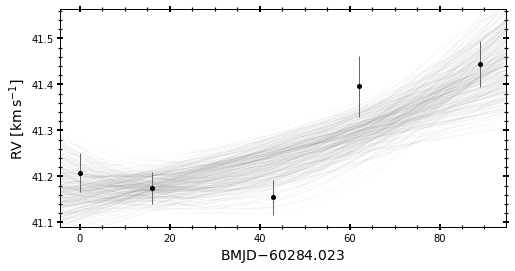

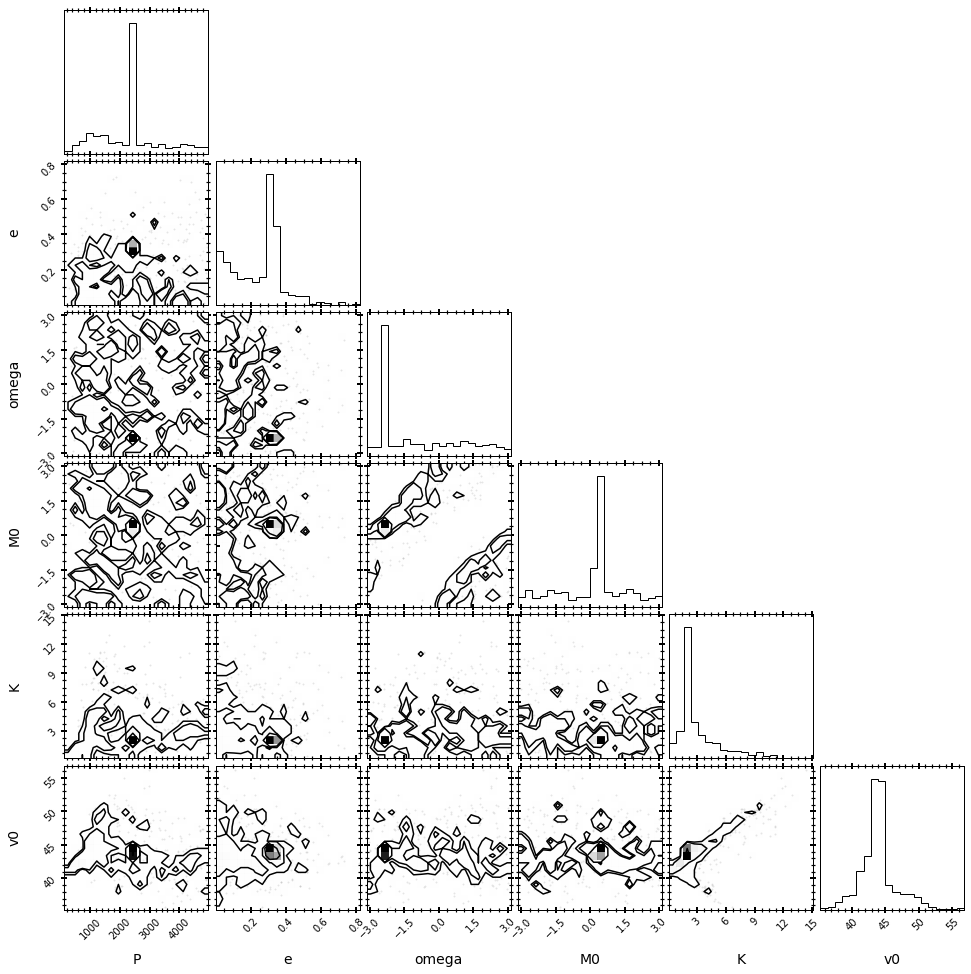

In [16]:
prior_samples_dict = dict.fromkeys(obj_dir)
joker_samples_dict = dict.fromkeys(obj_dir)
for ob in list(obj_dir.keys())[1:]:
    ps, js = test_tj(ob,prior_size=250_000,save=False,MCMC=True)
    prior_samples_dict[ob] = ps
    joker_samples_dict[ob] = js
    

In [18]:
joker_samples_dict[6]

<JokerSamples [P, e, omega, M0, s, K, v0] (157 samples)>

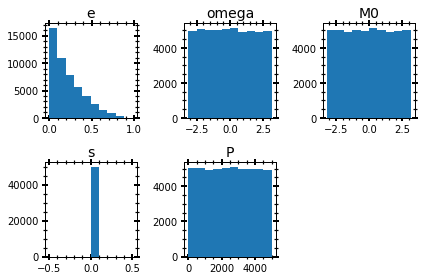

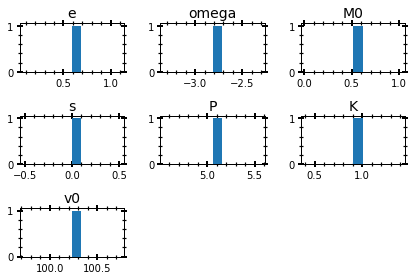

In [20]:
plt.figure()
for i,param in enumerate(['e', 'omega', 'M0', 's', 'P']):
    plt.subplot(2,3,i+1)
    plt.hist(prior_samples_dict[5][param].to_value())
    plt.title(param)
plt.tight_layout()

plt.figure()
for i,param in enumerate(['e', 'omega', 'M0', 's', 'P','K','v0']):
    plt.subplot(3,3,i+1)
    plt.hist(joker_samples_dict[5][param].to_value())
    plt.title(param)
plt.tight_layout()